# **Downwelling irradiance model**

## Model implementation with validation

This notebook presents the implementation of a downwelling irrandiance model considering atmospheric parameters and clear sky conditions. The model is based on field measurements for comparison.

**Author:** [Bruno Rech](https://github.com/b-rech) | **Created on:** 19 January 2025

* * *

### Dependencies

Read the documentation at the repository for further details.

**Important:** you need to authenticate and generate a token in your first access to Google Earth Engine. A Google Cloud project is required for this purpose. The token is valid for 7 days.

In [3]:
# Import libraries
import geemap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pvlib import spectrum, solarposition, irradiance, atmosphere

# Import auxiliary functions from another notebook
# Make sure that it is in the same folder as this one
%run auxiliary_functions.ipynb

### Field data

We need to open and configure the radiometric data from field measurements. For more details about the used function you may refer to the auxiliary functions notebook.

In [5]:
# Inform the time zone of the input file
# and the desired time zone of the output
# Satlantic usually comes in UTC,
# TriOS in America/Sao_Paulo
tz_input = 'UTC'
tz_output = 'America/Sao_Paulo'

# Load data
es = openFieldData('Es_satlantic_alcatrazes_20231221.csv',
                   equipment='satlantic',
                   tz_input=tz_input,
                   tz_output=tz_output)

# Date of field data acquisition (yyyy-mm-dd)
date = '2023-12-21'

es.head()

,wl,09:37,10:07,10:28,10:53,11:07,11:26,13:40
0,360,0.544159,0.593265,0.604905,0.679392,0.580461,0.714478,0.584489
1,361,0.554770,0.605154,0.617199,0.693202,0.591596,0.729324,0.596212
2,362,0.569146,0.620614,0.632742,0.711172,0.607525,0.748171,0.611153
3,363,0.583917,0.636478,0.649108,0.729557,0.623592,0.767214,0.626626
4,364,0.598499,0.652528,0.665025,0.747614,0.639944,0.786412,0.642185


### Atmospheric parameters

The required atmospheric parameters are retrieved from datasets available in Google Earth Engine.

Please draw a rectangle below indicating the region of interest (ROI):

In [6]:
# Create map
Map = geemap.Map(zoom=3)

# Draw region of interest
Map.draw_features
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Let's extract the information from the ROI polygon:

In [7]:
# Get region of interest
roi = ee.FeatureCollection(Map.draw_features)

# Get centroid
centroid = (roi
            .first()
            .geometry()
            .centroid(maxError=1)
            .getInfo()['coordinates'])

# Get latitude and longitude separately
lat, lon = centroid[1], centroid[0]

print(f'Centroid at latitude {lat:.4f} and longitude {lon:.4f}')

Centroid at latitude -24.1031 and longitude -45.7011


Now we can retrieve the parameters.

**Important:** the aerosol optical depth (AOD) product from MODIS has gaps. Therefore, the algorithm was designed to expand the time window when data are not available. You can check the selected time window in the output below. Furthermore, atmospheric pressure can only be calculated in continental regions where the digital elevation model is available; otherwise, a default value at sea level is used (and indicated).

In [8]:
# Get parameters
aod_550, ozone, water, pressure = atmParams(date, roi)

Mean AOD: 0.202 (time window: 3)
Mean ozone column: 0.273 atm-cm
Water in the atmosphere: 3.95 cm
Atmospheric pressure: 101320 Pa (default)


### Model implementation

We need to provide aditional data related to surface positioning. Modify if necessary.

In [9]:
# Surface inclination (water = 0)
tilt = 0

# Azimuth (North=0)
# As inclination is zero, azimuth should not
# make any difference
azimuth = 0

# Surface albedo (water is low)
albedo = 0.05

# Times of interest (retrieved from field data)
times = [pd.to_datetime(f'{date} {t}').tz_localize(tz_output)
         for t in es.columns[1:]]

# Solar position considering time and location
solpos = solarposition.get_solarposition(times, lat, lon)

# Area of interest
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

# Relative airmass at sea level
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith)

Finally, we can get the irradiance spectra:

In [10]:
model_spec = spectrum.spectrl2(apparent_zenith=solpos.apparent_zenith,
                               aoi=aoi,
                               surface_tilt=tilt,
                               ground_albedo=albedo,
                               surface_pressure=pressure,
                               relative_airmass=relative_airmass,
                               precipitable_water=water,
                               ozone=ozone,
                               aerosol_turbidity_500nm=aod_550)

Let's create an irradiance (global = direct + diffuse) dataframe:

In [11]:
# Get a dataframe
esm = pd.DataFrame(model_spec['poa_global'])

# Colnames are the times
esm.columns = [t.strftime('%H:%M') for t in times]

# Set wavelengths
esm['wl'] = model_spec['wavelength']

# Filter wavelengths according to the field data
esm = esm[(esm.wl >= es.wl.min()) & (esm.wl <= es.wl.max())]

esm.reset_index(drop=True, inplace=True)
esm.head()

,09:37,10:07,10:28,10:53,11:07,11:26,13:40,wl
0,0.542660,0.596146,0.627121,0.656379,0.668955,0.681489,0.618283,360.0
1,0.649550,0.712430,0.748772,0.783058,0.797783,0.812452,0.738408,370.0
2,0.665219,0.728441,0.764919,0.799295,0.814049,0.828740,0.754520,380.0
3,0.645067,0.705258,0.739936,0.772586,0.786591,0.800531,0.730054,390.0
4,0.952454,1.039741,1.089968,1.137220,1.157477,1.177636,1.075659,400.0


### Model validation

We can compare modelled and field spectra using several error metrics:

In [12]:
# Round model wavelengths
esm['wl'] = esm.wl.round().astype(int)

# Match wavelengths from field and model
es_sel = es[[x in esm.wl.tolist()
             for x in es.wl]].reset_index()

# Calculate error metrics
error_metrics = errorMetrics(data=esm,
                             ref=es_sel,
                             colnames=es.columns[1:])

error_metrics

,point,r,pvalue,mbe,mpe,mae,mape,rmse,rmspe,sam
0,09:37,0.991647,9.969484e-33,-0.009512,-0.008174,0.027502,0.023634,0.040770,0.035036,0.032471
1,10:07,0.992476,1.611015e-33,-0.011031,-0.008756,0.028753,0.022823,0.041782,0.033165,0.030459
2,10:28,0.992774,7.959814e-34,0.008435,0.006515,0.026370,0.020369,0.040512,0.031293,0.029997
3,10:53,0.991323,1.936627e-32,-0.145613,-0.097103,0.149060,0.099401,0.160700,0.107164,0.032722
4,11:07,0.992266,2.605417e-33,0.166323,0.137522,0.166323,0.137522,0.172521,0.142646,0.032291
5,11:26,0.989556,4.892302e-31,-0.188193,-0.118688,0.189169,0.119303,0.203502,0.128343,0.034845
6,13:40,0.992651,1.068716e-33,0.056523,0.045913,0.057528,0.046730,0.067800,0.055074,0.029728


Lastly, let's plot the spectra:

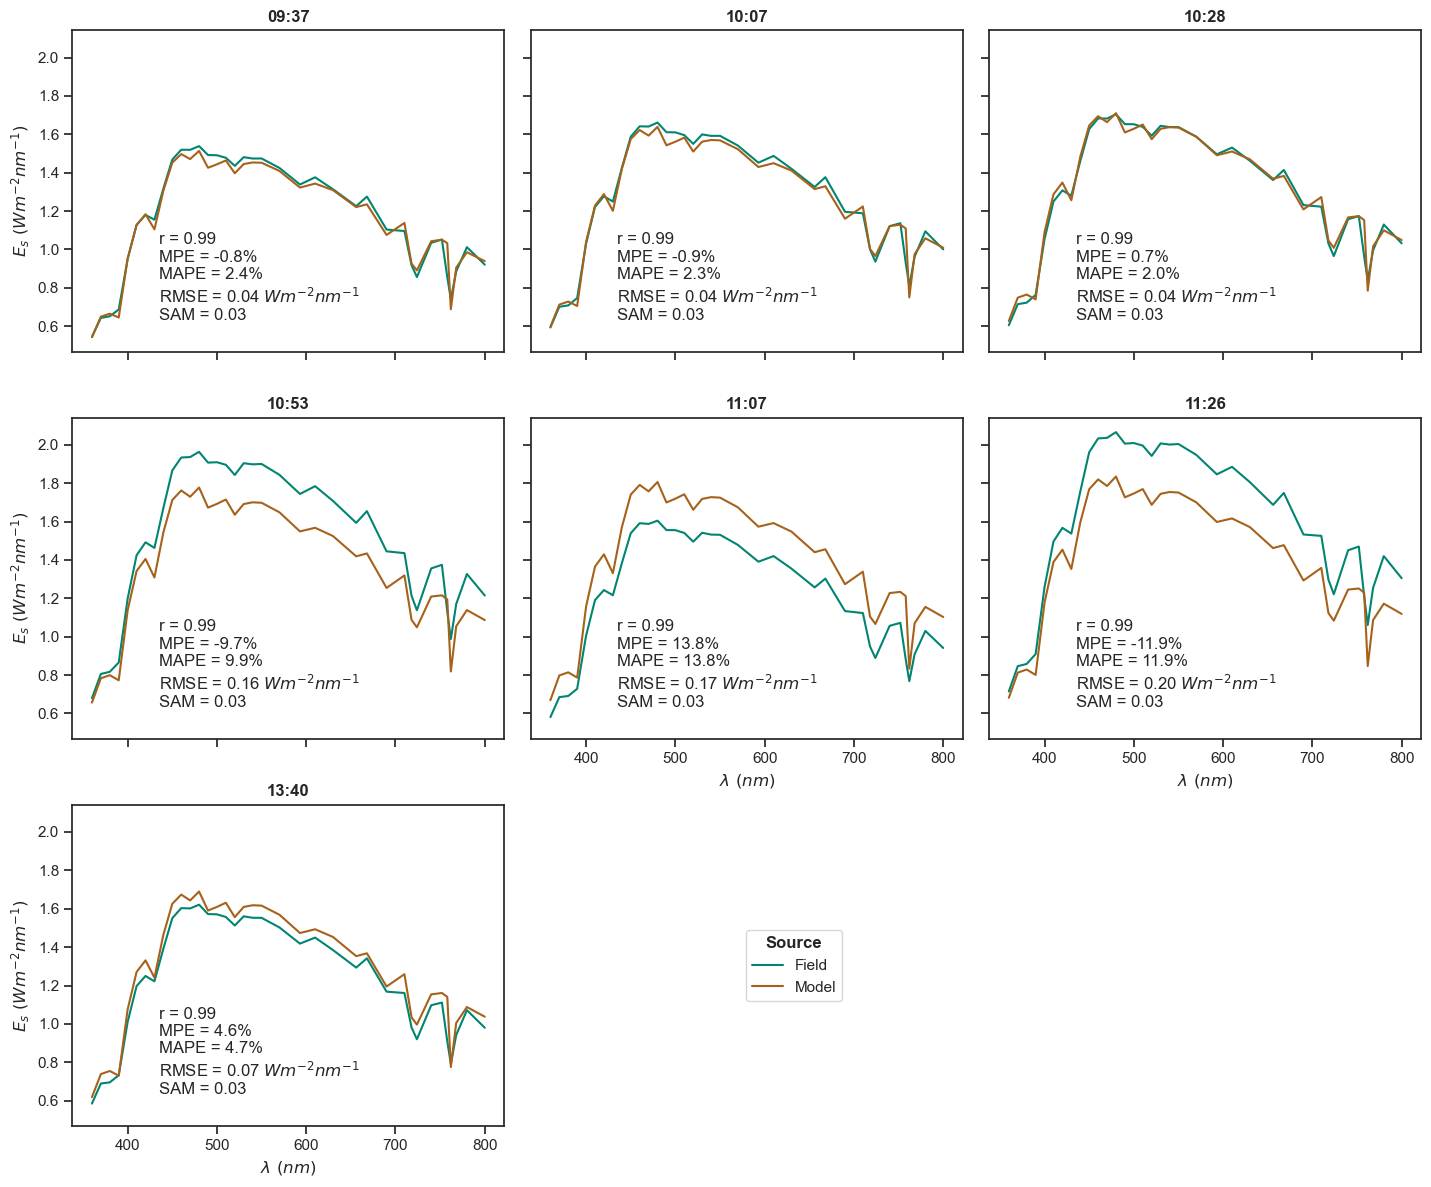

In [13]:
# Dataframes para formato longo
es_long = es_sel.melt(id_vars='wl',
                      var_name='time',
                      value_name='es')

esm_long = esm.melt(id_vars='wl',
                    var_name='time',
                    value_name='esm')

# Unir dataframes
es_plot = es_long.merge(esm_long, on=('wl', 'time'))

# Set plot theme
sns.set_theme(context='notebook',
              style='ticks')

# Create plot
plotSpectra(es_plot, error_metrics)